In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
import tqdm as tqdm
#import tqdm.notebook as tqdm
import multiprocessing

Welcome to JupyROOT 6.20/06


In [2]:
N_cpu=multiprocessing.cpu_count()
N_Threads = "%d" % (N_cpu-2)

# THR analysis
* Noise vs VCASN
* Area vs PCA ratio 2D Histo

In [4]:
#Run packet analyzer script for all threshold
Data_folder_path="Data"

Run_Analysis = True
Force_Analysis = False

files=os.listdir(Data_folder_path + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith('Data_VCASN_'):
            root_file=Path("Analyzed_Data/"+name+"/"+name+".root")
            root_file_existence_flag=root_file.is_file()
            if (Run_Analysis and not root_file_existence_flag) or Force_Analysis:
                args = "-f "+name+" -Df "+Data_folder_path+" -d 1 10 "
                %run 'Packet_analyzer.py' {args}
            

100%|██████████| 374/374 [00:00<00:00, 629482.22it/s]


In [5]:
#Noise dependace on VCASN

VCASN_val    = []
Noise_points = []


files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        V_CASN_THR=int(name.split('_')[2], base=16)
        VCASN_val = np.append(VCASN_val,V_CASN_THR)
        
        file=open("Data/"+name+"/Stat_"+name+".txt")
        line=file.readlines()
        for l in line:
            if (l.startswith("Readout_time")):
                time=float(l.split('=')[1].strip()[:-1])
            if (l.startswith("Strobe")):
                Strobe=int(l.split('=')[1].strip()[:-1])
            if (l.startswith("Gap")):
                Gap=int(l.split('=')[1].strip()[:-1])
        
        filename="Analyzed_Data/"+name+"/"+name+".root"
        root_file_1  = ROOT.TFile.Open(filename)
        Data_tree    = root_file_1.Get("tree")
        Noise        = Data_tree.AsMatrix(['Rnoise'])
        Noise_points = np.append(Noise_points,Noise[0]*(Strobe+Gap)/(time*Strobe))
        

/home/gabriele/anaconda3/envs/rootenv/lib/python3.8/site-packages/ROOT.py:352: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  flat_matrix_ptr = _root.ROOT.Internal.RDF.GetVectorAddress(dtype)(flat_matrix)



****************************************
Minimizer is Minuit / Migrad
Chi2                      =  3.02551e+07
NDf                       =            8
Edm                       =  1.18957e-06
NCalls                    =          905
p0                        =   0.00212687   +/-   0.00191963  
p1                        =      4.15486   +/-   0.21373     
p2                        =      -978.34   +/-   813.831     


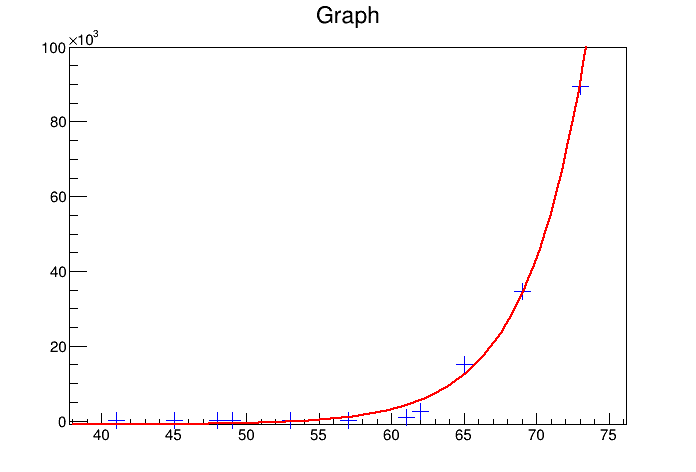

In [17]:
#plt.plot(VCASN_val,Noise_points, 'bo')
Noise_graph = ROOT.TGraph(len(Noise_points),VCASN_val,Noise_points)
Exp_func    = ROOT.TF1('Exp_func','[0]*exp(x/[1])+[2]')
Pol4        = ROOT.TF1('Pol4','pol4')

Noise_graph.SetMarkerColor(4)
Noise_graph.SetMarkerStyle(2)
Noise_graph.SetMarkerSize(2)
YAxis = Noise_graph.GetYaxis()
YAxis.SetRangeUser(-1000,100000)

Exp_func.SetParameters(5,8,0.1)

Noise_graph.Fit('Exp_func')

NPC = ROOT.TCanvas()

Noise_graph.Draw('AP')
NPC.Draw()

In [7]:
#convert the TTree in np arrays
name        = "gold_alpide_27_DC_5m_run4_090121"
filename    = "Analyzed_Data/"+name+"/"+name+".root"
root_file = ROOT.TFile.Open(filename)
Data_tree   = root_file.Get("tree")

Areas_AxP  = Data_tree.AsMatrix(['Rareas'])
Means_AxP  = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios_AxP = Data_tree.AsMatrix(['Rratios'])

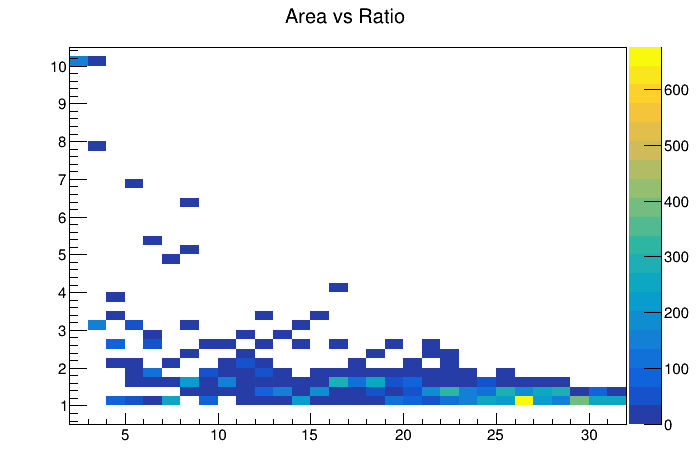

In [8]:
ar_max=int(np.amax(Areas_AxP))
A_R_Histo = ROOT.TH2D('A_R_Histo','Area vs Ratio',ar_max-2,2,ar_max,40,0.5,10.5)

for i in range(len(Areas_AxP)):
    A_R_Histo.Fill(Areas_AxP[i],Ratios_AxP[i])
    
    
ARC=ROOT.TCanvas()
A_R_Histo.Draw("COLZ")
A_R_Histo.SetStats(False)
ARC.Draw()